In [81]:
import math
from inspect import isfunction
from functools import partial
import random
import IPython

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from datasets import load_dataset, load_from_disk

from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from torch.optim import Adam

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import matplotlib.pyplot as plt

In [82]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(53)
random.seed(53)
np.random.seed(53)

In [83]:
DEVICE

'cuda'

In [84]:
dataset = load_dataset("mnist")  
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [85]:
train_dataset = dataset['train']
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [49]:
image = train_dataset[0]['image']
image

In [86]:
image_array = np.asarray(image, dtype=np.uint8)
print(f"shape of the image: {image_array.shape}")
print(f"min: {image_array.min()}, max: {image_array.max()}")

shape of the image: (28, 28)
min: 0, max: 255


In [87]:
def get_dataset(data_path, batch_size, test = False):
    
    dataset = load_dataset(data_path)  

    transform = Compose([
        transforms.RandomHorizontalFlip(),  
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1)  
    ])

    def transforms_im(examples):
        examples['pixel_values'] = [transform(image) for image in examples['image']]
        del examples['image']
        return examples

    dataset = dataset.with_transform(transforms_im).remove_columns('label')  # We don't need it 
    channels, image_size, _ = dataset['train'][0]['pixel_values'].shape
        
    if test:
        dataloader = DataLoader(dataset['test'], batch_size=batch_size)
    else:
        dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)

    len_dataloader = len(dataloader)
    print(f"channels: {channels}, image dimension: {image_size}, len_dataloader: {len_dataloader}")  
    
    return dataloader, channels, image_size, len_dataloader

In [88]:
batch_size = 64
data_path = "mnist"  

In [89]:
train_dataloader, channels, image_size, len_dataloader = get_dataset(data_path, batch_size)

batch_image = next(iter(train_dataloader))['pixel_values']
batch_image.shape

channels: 1, image dimension: 28, len_dataloader: 938


torch.Size([64, 1, 28, 28])

In [90]:
def normalize_im(images):
    shape = images.shape
    images = images.view(shape[0], -1)
    images -= images.min(1, keepdim=True)[0]
    images /= images.max(1, keepdim=True)[0]
    return images.view(shape)

def show_images(batch):
    plt.imshow(torch.permute(make_grid(normalize_im(batch)), (1,2,0)))
    plt.show()

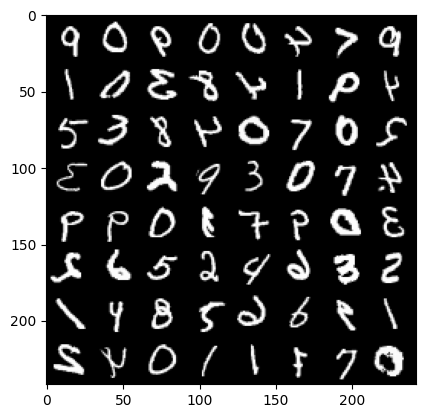

In [91]:
show_images(batch_image[:])

## Forward Diffusion

In [92]:
# Different type of beta schedule
def linear_beta_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    """
    linar schedule from the original DDPM paper https://arxiv.org/abs/2006.11239
    """
    return torch.linspace(beta_start, beta_end, timesteps)


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


- $ \beta_t $: betas
- $ \sqrt{\frac{1}{\alpha_t}} $: sqrt_recip_alphas
- $ \sqrt{\bar{\alpha}_t} $: sqrt_alphas_cumprod
- $ \sqrt{1-\bar{\alpha}_t} $: sqrt_one_minus_alphas_cumprod
- $ \tilde{\beta}_t = \beta_t\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} $: posterior_variance

In [93]:
def get_alph_bet(timesteps, schedule=cosine_beta_schedule):
    

    betas = schedule(timesteps)

    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0) 
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)


    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
    
    const_dict = {
        'betas': betas,
        'sqrt_recip_alphas': sqrt_recip_alphas,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'posterior_variance': posterior_variance
    }
    
    return const_dict

### Definition of $ q(x_t|x_0) $

In [94]:
def extract(constants, batch_t, x_shape):
    diffusion_batch_size = batch_t.shape[0]
    
    out = constants.gather(-1, batch_t.cpu()) 
    
    return out.reshape(diffusion_batch_size, *((1,) * (len(x_shape) - 1))).to(batch_t.device)


In [95]:
def q_sample(constants_dict, batch_x0, batch_t, noise=None):
    if noise is None:
        noise = torch.randn_like(batch_x0)

    sqrt_alphas_cumprod_t = extract(constants_dict['sqrt_alphas_cumprod'], batch_t, batch_x0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_x0.shape
    )

    return sqrt_alphas_cumprod_t * batch_x0 + sqrt_one_minus_alphas_cumprod_t * noise

timesteps: tensor([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
        210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, 390, 405,
        420, 435, 450, 465, 480, 495, 510, 525, 540, 555, 570, 585, 600, 615,
        630, 645, 660, 675, 690, 705, 720, 735, 750, 765, 780, 795, 810, 825,
        840, 855, 870, 885, 900, 915, 930, 945])
Original images:


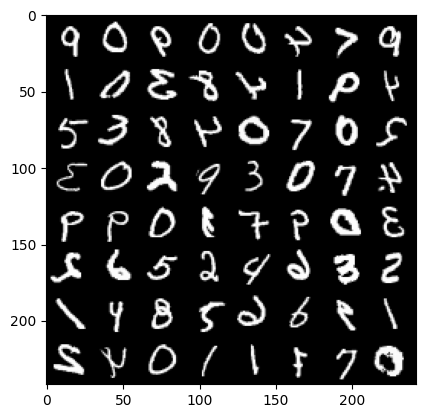

Noised images with linear shedule:


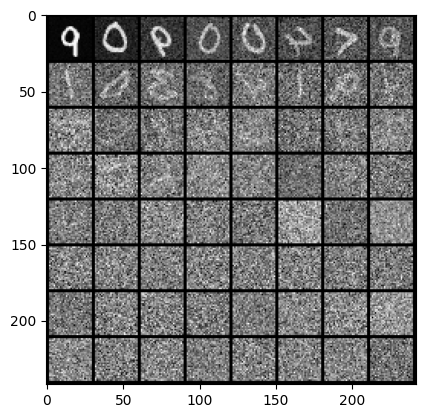

Noised images with cosine shedule:


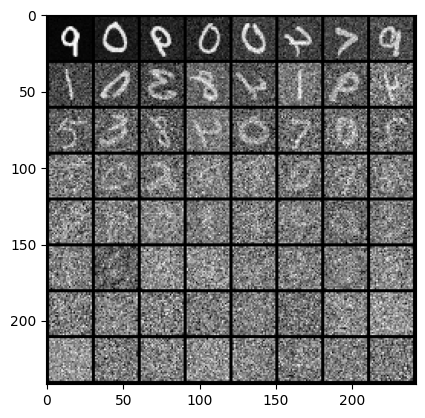

In [96]:
T = 1000
const_linear_dict = get_alph_bet(T, schedule=linear_beta_schedule)
const_cosine_dict = get_alph_bet(T, schedule=cosine_beta_schedule)

batch_t = torch.arange(batch_size)*(T//batch_size)  
print(f"timesteps: {batch_t}")
noisy_batch_linear = q_sample(const_linear_dict, batch_image, batch_t, noise=None)
noisy_batch_cosine = q_sample(const_cosine_dict, batch_image, batch_t, noise=None)

print("Original images:")
show_images(batch_image[:])

print("Noised images with linear shedule:")
show_images(noisy_batch_linear[:])

print("Noised images with cosine shedule:")
show_images(noisy_batch_cosine[:])

## Reverse Diffusion Process

In [97]:
from model import Unet

model = Unet(   
    dim=28,
    init_dim=None,
    out_dim=None,
    dim_mults=(1, 2, 4),
    channels=1,
    with_time_emb=True,
    convnext_mult=2,
)

In [98]:
@torch.no_grad()
def p_sample(constants_dict, batch_xt, predicted_noise, batch_t):

    betas_t = extract(constants_dict['betas'], batch_t, batch_xt.shape).to(batch_xt.device)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_xt.shape
    ).to(batch_xt.device)
    sqrt_recip_alphas_t = extract(
        constants_dict['sqrt_recip_alphas'], batch_t, batch_xt.shape
    ).to(batch_xt.device)
    
    model_mean = sqrt_recip_alphas_t * (
        batch_xt - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )
    

    predicted_image = torch.zeros(batch_xt.shape).to(batch_xt.device)
    t_zero_index = (batch_t == torch.zeros(batch_t.shape).to(batch_xt.device))
    
    posterior_variance_t = extract(constants_dict['posterior_variance'], batch_t, batch_xt.shape)
    noise = torch.randn_like(batch_xt)  
    predicted_image[~t_zero_index] = model_mean[~t_zero_index] + (
        torch.sqrt(posterior_variance_t[~t_zero_index]) * noise[~t_zero_index]
    ) 
    

    predicted_image[t_zero_index] = model_mean[t_zero_index]
    
    return predicted_image

## Sampling 

In [99]:
@torch.no_grad()
def sampling(model, shape, T, constants_dict):
    b = shape[0]
    
    batch_xt = torch.randn(shape, device=DEVICE)
    
    batch_t = torch.ones(shape[0]) * T  
    batch_t = batch_t.type(torch.int64).to(DEVICE)
    
    imgs = []

    for t in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        batch_t -= 1
        predicted_noise = model(batch_xt, batch_t)
        
        batch_xt = p_sample(constants_dict, batch_xt, predicted_noise, batch_t)
        
        imgs.append(batch_xt.cpu())
        
    return imgs

## Training


In [101]:
# Dataset parameters
batch_size = 1
data_path = "mnist" 
train_dataloader, channels, image_size, len_dataloader = get_dataset(data_path, batch_size)

channels: 1, image dimension: 28, len_dataloader: 60000


In [102]:
constants_dict = get_alph_bet(T, schedule=linear_beta_schedule)

In [103]:
epochs = 3
T = 1000  # = T

In [104]:
model = Unet(   
    dim=image_size,
    init_dim=None,
    out_dim=None,
    dim_mults=(1, 2, 4),
    channels=channels,
    with_time_emb=True,
    convnext_mult=2,
).to(DEVICE)


In [105]:
criterion = nn.SmoothL1Loss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [106]:
for epoch in range(epochs):
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in loop:
        optimizer.zero_grad()

        batch_size_iter = batch["pixel_values"].shape[0]
        batch_image = batch["pixel_values"].to(DEVICE)

        batch_t = torch.randint(0, T, (batch_size_iter,), device=DEVICE).long()
        
        noise = torch.randn_like(batch_image)
        
        x_noisy = q_sample(constants_dict, batch_image, batch_t, noise=noise)
        predicted_noise = model(x_noisy, batch_t)
        
        loss = criterion(noise, predicted_noise)

        loop.set_postfix(loss=loss.item())

        loss.backward()
        optimizer.step()

        
print("check generation:")  
list_gen_imgs = sampling(model, (batch_size, channels, image_size, image_size), T, constants_dict)
show_images(list_gen_imgs[-1])
    

Epoch 1/3:   0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## View of the diffusion process

In [79]:
def make_gif(frame_list):
    to_pil = ToPILImage()
    frames = [to_pil(make_grid(normalize_im(tens_im))) for tens_im in frame_list]
    frame_one = frames[0]
    frame_one.save("sampling.gif.png", format="GIF", append_images=frames[::5], save_all=True, duration=10, loop=0)
    
    return IPython.display.Image(filename="./sampling.gif.png")

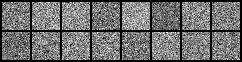

In [80]:
make_gif(list_gen_imgs)